In [126]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 单负荷数据集处理
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length, pred_length):
        self.data = data
        self.seq_length = seq_length
        self.pred_length = pred_length

    def __len__(self):
        return len(self.data) - self.seq_length - self.pred_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length:index + self.seq_length + self.pred_length]
        y = y.reshape(-1)
        return x, y



class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


def normalize_data(df):
    df = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return df

# 读取训练集和验证集的数据
df = pd.read_csv('data/Area1_Load_hour.csv')
df = df[df['Time'] <= '2015-01-11']
df = df.drop('Time', axis=1)

# 选取训练集和验证集的数据
df = normalize_data(df)
m_all = len(df) # 数据集总行数
m_val = 110*96 # 验证集数量
m_test = 110*96 # 测试集数量
m_train = m_all - m_test - m_val # 训练集数量

train_df = df.iloc[:m_train]
val_df = df.iloc[m_train:m_train+m_val]
test_df = df.iloc[m_train+m_val:]
print(train_df.shape, val_df.shape, test_df.shape)


(31704, 1) (10560, 1) (10560, 1)


torch.Size([672, 1]) torch.Size([96])
Epoch 10/20, Train Loss: 0.0089, Val Loss: 0.0123
Epoch 20/20, Train Loss: 0.0067, Val Loss: 0.0097
Best Val Loss: 0.0097


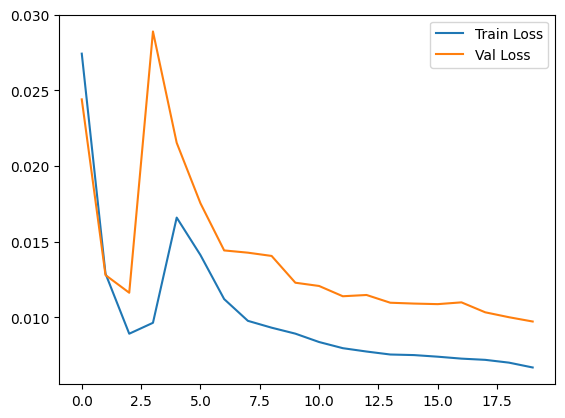

In [127]:
# 将数据集转换为PyTorch的Tensor
train_data = torch.tensor(train_df['Load'].values, dtype=torch.float32).unsqueeze(1)
val_data = torch.tensor(val_df['Load'].values, dtype=torch.float32).unsqueeze(1)

# 创建训练集和验证集的数据集对象
seq_length = 96*7
pred_length = 96
train_dataset = TimeSeriesDataset(train_data, seq_length,pred_length)
val_dataset = TimeSeriesDataset(val_data, seq_length,pred_length)
# 查看第一个数据
x, y = train_dataset[0]
print(x.shape, y.shape)
# 创建数据加载器
batch_size = 96
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 定义模型参数
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 96

# 创建模型实例
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 设置训练设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 将模型移动到训练设备
model.to(device)

# 定义训练参数
""" 在这里改变学习率和训练次数 """
num_epochs = 20
learning_rate = 0.001

# 定义损失函数和优化器

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 初始化最好的验证集损失
best_val_loss = float('inf')

# 记录train_loss和val_loss
train_loss_list = []
val_loss_list = []

# 记录预测值和真实值
predictions_train = []
# 训练模型
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    train_loss = 0.0

    for i, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss)
    # 在验证集上进行评估
    model.eval()  # 设置模型为评估模式
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_loss_list.append(val_loss)
    # 每隔10次打印训练结果
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 保存最好的模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

print(f'Best Val Loss: {best_val_loss:.4f}')
# 画出train_loss和val_loss
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.legend()
plt.show()
# 打印最好的验证集损失


(9792, 96)
(9792, 96)


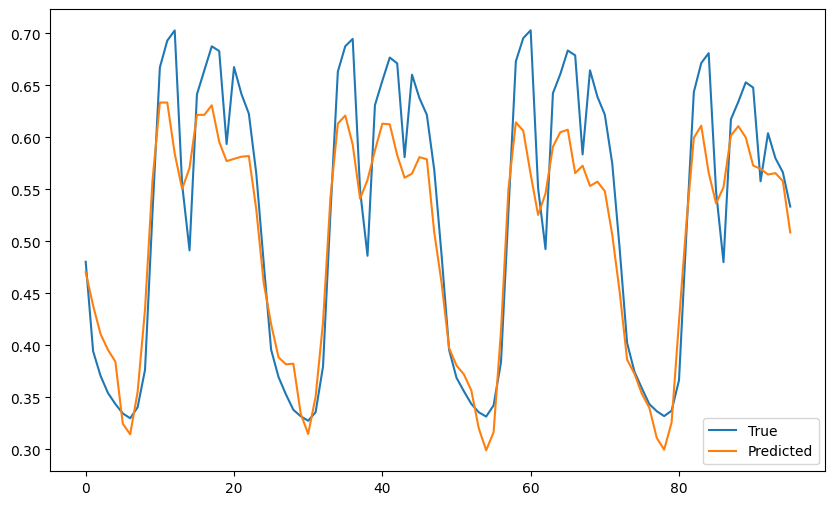

In [131]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# 将数据集转换为PyTorch的Tensor
test_data = torch.tensor(test_df['Load'].values, dtype=torch.float32).unsqueeze(1)

# 创建测试集的数据集对象
seq_length = 96*7
pred_length = 96
test_dataset = TimeSeriesDataset(test_data, seq_length, pred_length)

# 创建数据加载器
batch_size = 96
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 加载已训练好的模型参数
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()


# 在测试集上进行预测
predictions = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.to(device)

        outputs = model(inputs)
        predictions.append(outputs.detach().cpu().numpy())

# 创建真实值数据集
def create_targets(data, seq_length, pred_length):
    m = len(data) - seq_length - pred_length
    targets = np.zeros((m, pred_length))
    for i in range(m):
        x = data[i:i + seq_length]
        y = data[i + seq_length:i + seq_length + pred_length]
        targets[i] = y
    return targets
test_true = create_targets(test_df['Load'].values, seq_length, pred_length)

# 将预测结果转换为pred_length维数组
predictions = np.concatenate(predictions, axis=0)
print(predictions.shape)
print(test_true.shape)
# 画出预测结果
plt.figure(figsize=(10, 6))
# 选择天数
n = 9791
plt.plot(test_true[n], label='True')
plt.plot(predictions[n], label='Predicted')
plt.legend()
plt.show()


(940032,)
(940032,)


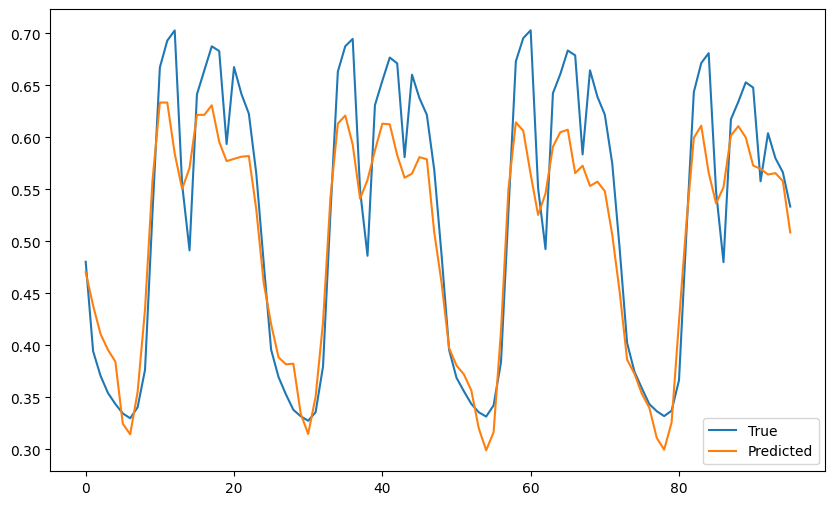

In [136]:
test_true = test_true.flatten()
# 将预测结果转换为pred_length维数组
predictions = predictions.flatten()
print(predictions.shape)
print(test_true.shape)
# 画出预测结果
plt.figure(figsize=(10, 6))
plt.plot(test_true[-96:], label='True')
plt.plot(predictions[-96:], label='Predicted')
plt.legend()
plt.show()

In [135]:
# 计算RMSE
rmse = sqrt(mean_squared_error(test_true, predictions))
print(f'RMSE: {rmse:.2f}')
# 计算MAPE
mape = mean_absolute_percentage_error(test_true, predictions)*100
print(f'MAPE: {mape:.2f}%')


RMSE: 0.11
MAPE: 18.90%
